  File "c:\Users\Tilak Devi\anaconda3\envs\main\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\Tilak Devi\anaconda3\envs\main\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Tilak Devi\anaconda3\envs\main\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Tilak Devi\anaconda3\envs\main\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 16418, number of negative: 41149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 57567, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285198 -> initscore=-0.918821
[LightGBM] [Info] Start training from score -0.918821
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0        Random Forest  0.722485   0.551210  0.144250  0.228660  0.632974
1             CatBoost  0.719219   0.567452  0.064571  0.115948  0.623262
2             LightGBM  0.718594   0.612500  0.035819  0.067680  0.616908
3              XGBoost  0.716440   0.515520  0.093080  0.157688  0.

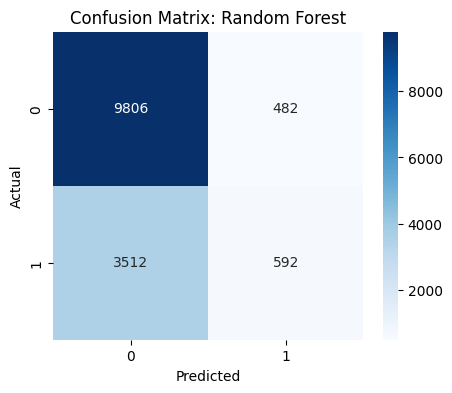

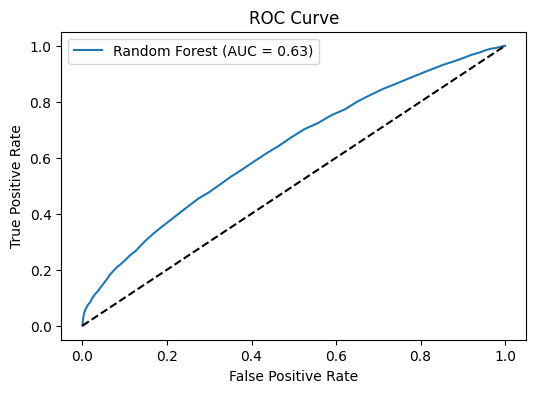

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

# -------------------------------
# Step 1: Load Cleaned Data
# -------------------------------

df = pd.read_csv("cleaned_appointments.csv")

# Drop non-numeric/raw datetime if still present
drop_cols = ['scheduledday', 'appointmentday']
X = df.drop(columns=['no_show'] + [col for col in drop_cols if col in df.columns])
y = df['no_show']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------
# Step 2: Scale (for MLP, LogReg)
# -------------------------------

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------------
# Step 3: Train Models
# -------------------------------

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
}

# -------------------------------
# Step 4: Train and Evaluate
# -------------------------------

results = []

for name, model in models.items():
    if name in ["Logistic Regression", "MLP"]:
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
        probs = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        probs = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test, probs)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC AUC": auc
    })

# -------------------------------
# Step 5: Ensemble - Stacking
# -------------------------------

stack = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    ],
    final_estimator=LogisticRegression(),
    passthrough=True
)

stack.fit(X_train, y_train)
stack_preds = stack.predict(X_test)
stack_probs = stack.predict_proba(X_test)[:, 1]

results.append({
    "Model": "Stacking Ensemble",
    "Accuracy": accuracy_score(y_test, stack_preds),
    "Precision": precision_score(y_test, stack_preds),
    "Recall": recall_score(y_test, stack_preds),
    "F1 Score": f1_score(y_test, stack_preds),
    "ROC AUC": roc_auc_score(y_test, stack_probs)
})

# -------------------------------
# Step 6: Results Table
# -------------------------------

results_df = pd.DataFrame(results).sort_values(by="ROC AUC", ascending=False).reset_index(drop=True)
print(results_df)

# -------------------------------
# Step 7: Save Best Model Plots
# -------------------------------

best_model_name = results_df.iloc[0]['Model']
print(f"\nBest model: {best_model_name}")

# Use same logic to retrieve best model again
model_map = {r["Model"]: m for r, m in zip(results, list(models.values()) + [stack])}
best_model = model_map[best_model_name]

# Predict and plot
if best_model_name in ["Logistic Regression", "MLP"]:
    best_preds = best_model.predict(X_test_scaled)
    best_probs = best_model.predict_proba(X_test_scaled)[:, 1]
else:
    best_preds = best_model.predict(X_test)
    best_probs = best_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, best_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix: {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('output/confusion_matrix.png')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, best_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {roc_auc_score(y_test, best_probs):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig('output/roc_curve.png')
plt.show()


In [2]:
import joblib
import os

# Create output dir if not exists
os.makedirs('output', exist_ok=True)

# Save best model
joblib.dump(best_model, 'output/best_model.pkl')
print(f"✅ Best model '{best_model_name}' saved to output/best_model.pkl")


✅ Best model 'Random Forest' saved to output/best_model.pkl
